In [2]:
from sklearn.cross_decomposition import CCA
import numpy as np
import pickle
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from scipy.spatial import procrustes
from sklearn.decomposition import PCA

import sys
sys.path.insert(0, '../SAC/')
import kinematics_preprocessing_specs

import config

parser = config.config_parser()
args, unknown = parser.parse_known_args()

In [3]:
#Load the test data of nusim

with open('../test_data/test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)
    
print(test_data.keys())

dict_keys(['emg', 'rnn_activity', 'rnn_input', 'rnn_input_fp', 'kinematics_mbodies', 'kinematics_mtargets'])


In [4]:
#Get the timepoints of each condition per cycle
with open('../kinematics_data/kinematics.pkl', 'rb') as file:
    kin_train_test = pickle.load(file)
    
kin_train = kin_train_test['train']
kin_test = kin_train_test['test']

#First update the keys of self.kin_test
for cond in range(len(kin_test)):
    kin_test[len(kin_train) + cond] = kin_test.pop(cond)
    
kin = kin_train
kin.update(kin_test)

In [5]:
#Get the experimental neural data

with open('../nusim_neural_data/neural_activity_train.pkl', 'rb') as file:
    neural_train = pickle.load(file)

with open('../nusim_neural_data/neural_activity_test.pkl', 'rb') as file:
    neural_test = pickle.load(file)

#First update the keys of self.kin_test
for cond in range(len(neural_test)):
    neural_test[len(neural_train) + cond] = neural_test.pop(cond)
    
neural = neural_train
neural.update(neural_test)

In [28]:
conds = [kin[cond].shape[-1] for cond in range(len(kin))]
total_conds = len(conds)

#Select the cycle for each condition (training conditions followed by testing): 0 for 1st cycle and so on
#The number of elements should be equal to num_train_conditions + num_test_conditions
cycles = [2, 2, 2, 2, 2, 2]

#Number of fixedsteps in the start of each condition
n_fixedsteps= args.n_fixedsteps

In [30]:
#Load the network activities
A_agent = []

for idx, cond_activity in test_data['rnn_activity'].items():
    act_agent = cond_activity
    act_agent = act_agent[n_fixedsteps + cycles[idx] * conds[idx] : n_fixedsteps + (cycles[idx]+1) * conds[idx]]
    print(act_agent.shape)
    A_agent.append(act_agent[:, :])

(702, 256)
(803, 256)
(932, 256)
(1319, 256)
(619, 256)
(1106, 256)


In [32]:
# Load the experimental neural activities
A_exp = []
for cond in range(len(neural)):
    act_exp = neural[cond]
    print(act_exp.shape)
    A_exp.append(act_exp)

(702, 49)
(803, 49)
(932, 49)
(1319, 49)
(619, 49)
(1106, 49)


In [34]:
#index of the conds on which to do the procrustes analyses
conds_analysis = [0, 1, 2, 3, 4, 5]

In [36]:
#Condition on which to try the procrustes analysis
cond = 0

pc_exp = PCA(n_components= 49)
pc_agent = PCA(n_components= 49)

A_exp_pr = pc_exp.fit_transform(A_exp[cond])
A_agent_pr = pc_agent.fit_transform(A_agent[cond])

m1, m2, d = procrustes(A_exp_pr, A_agent_pr)
print(d)

0.13137013100577533


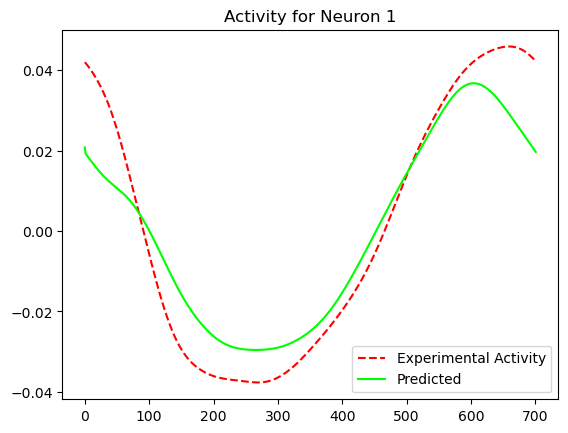

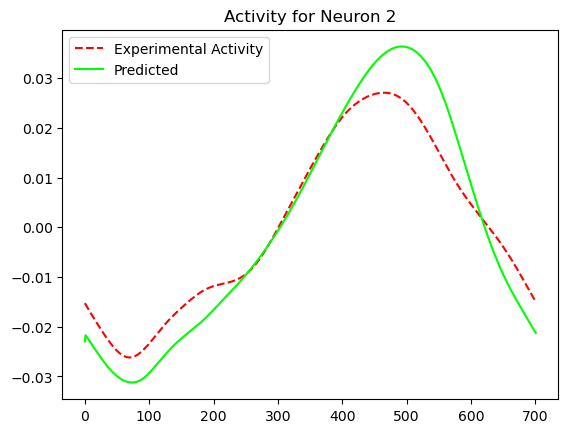

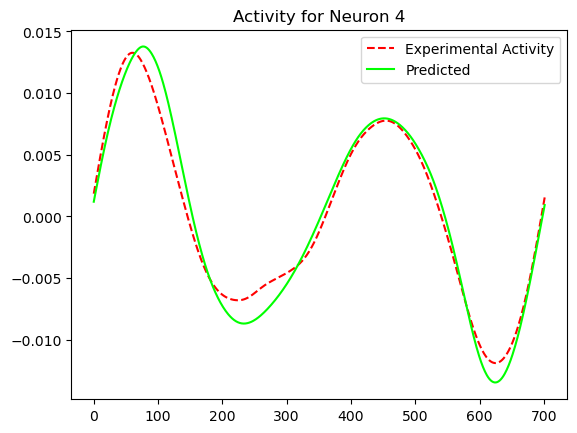

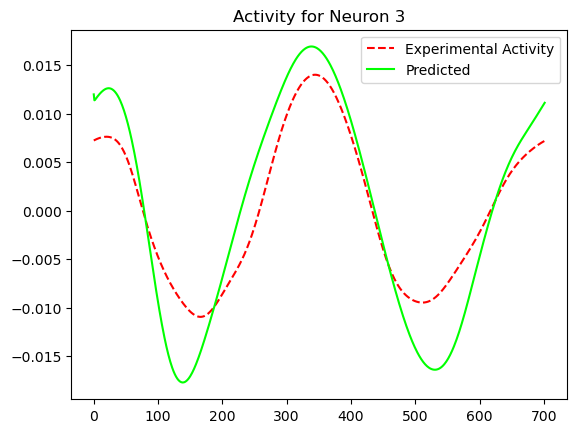

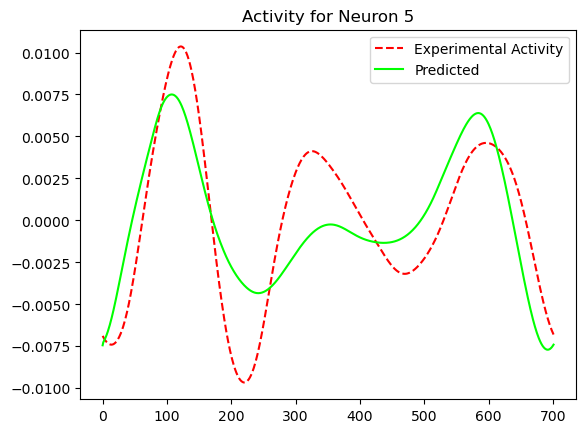

In [38]:
#Plot the first few neurons after the procrustes analysis
num_neurons2plot= 5

range_neurons = np.abs(np.max(A_exp_pr, axis= 0) - np.min(A_exp_pr, axis= 0))
neurons2plot = range_neurons.argsort()[-num_neurons2plot:][::-1]


for neuron2plot in neurons2plot:
    plt.plot(m1[:, neuron2plot], '--', c= (1, 0, 0), label= 'Experimental Activity')
    plt.plot(m2[:, neuron2plot], '-', c = (0, 1, 0), label= 'Predicted')
    
    plt.title(f"Activity for Neuron {neuron2plot+1}")
    plt.legend()
    plt.show()

In [39]:
#Condition on which to try the procrustes analysis
cond = 0

pc_exp = PCA(n_components= 3)
pc_agent = PCA(n_components= 3)

A_exp_pr = pc_exp.fit_transform(A_exp[cond])
A_agent_pr = pc_agent.fit_transform(A_agent[cond])

m1, m2, d = procrustes(A_exp_pr, A_agent_pr)
print(d)

0.1307083028068406


In [42]:
#Concatenate the musim activity for all conditions
for idx_cond, i_cond in enumerate(conds_analysis):
    
    if idx_cond == 0:
        A_agent_cum = A_agent[i_cond]
    else:
        A_agent_cum = np.concatenate((A_agent_cum, A_agent[i_cond]), axis=0)
        
#Concatenate the experimental neural activity for all conditions
for idx_cond, i_cond in enumerate(conds_analysis):
    if idx_cond == 0:
        A_exp_cum = A_exp[i_cond]
    else:
        A_exp_cum = np.concatenate((A_exp_cum, A_exp[i_cond]), axis=0)
        
print(A_agent_cum.shape)
print(A_exp_cum.shape)

(5481, 256)
(5481, 49)


In [44]:
#Do the procrustes on the cumulative activity

pc_exp = PCA(n_components= 49)
pc_agent = PCA(n_components= 49)

A_exp_pr = pc_exp.fit_transform(A_exp_cum)
A_agent_pr = pc_agent.fit_transform(A_agent_cum)

m1, m2, d = procrustes(A_exp_pr, A_agent_pr)
print(d)

0.27585668163819


In [46]:
#Do the procrustes on the cumulative activity

pc_exp = PCA(n_components= 3)
pc_agent = PCA(n_components= 3)

A_exp_pr = pc_exp.fit_transform(A_exp_cum)
A_agent_pr = pc_agent.fit_transform(A_agent_cum)

m1, m2, d = procrustes(A_exp_pr, A_agent_pr)
print(d)

0.3753416579762285
